Jack and Sacha Exoplanet Project:

The paper "Cool Jupiters greatly outnumber their toasty siblings: occurrence rates
from the Anglo-Australian Planet Search," comes to the conclusion that "cool jupiters" are more common than "hot jupiters." A cool jupiter is a planet with a MJup(Jupiter mass) greater than 0.3 and an orbital period greater than 100 days. A hot jupiter is a planet with a MJup(Jupiter mass) greater than 0.3 and an orbital period less than or equal to 100 days. We are setting out to apply the test present in this paper to the larger kepler data base to see if the claim holds up.

the paper: https://ui.adsabs.harvard.edu/abs/2020MNRAS.492..377W/abstract

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#For Preprocessing
import sklearn as sc
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#For non GPU function acceleration
from numba import jit


#For Neural net training
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow.keras.metrics

#check if gpu is availble (requires cuda toolkit and cuda deep learning library)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


We only care about the name, stellar mass, planetary mass, radius from the star, stellar radius, temperature
Our correletion is part of our main question of whether the majority of jupiter sized worlds are considered cold jupiters.

There was a helpful legend that labeled the names of the columns, but we had to delete the legend to get it to load because the legened was not commented out.

In [2]:
data = pd.read_csv('keplerFullTable.csv')
print("data=",data.shape)


data= (32112, 92)


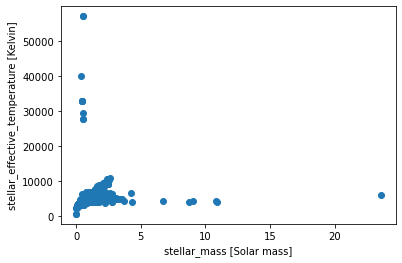

In [3]:
plt.scatter(data['st_mass'], data['st_teff'])
plt.xlabel('stellar_mass [Solar mass]')
plt.ylabel('stellar_effective_temperature [Kelvin]')
plt.show() 

We found a correlation between stellar mass and temperature. This is important for figuring out the planetary temperature. This corelation occurs because in a general bigger star will make the planet have a hotter temperature.

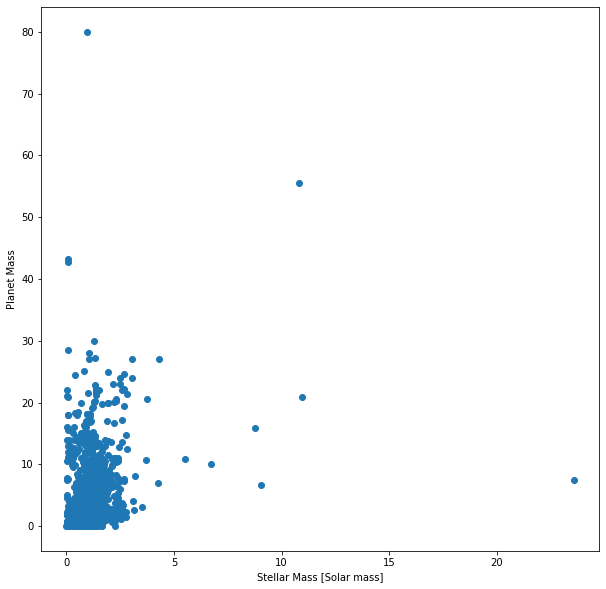

In [4]:
plt.scatter(data['st_mass'], data['pl_bmassj'])
plt.xlabel('Stellar Mass [Solar mass]')
plt.ylabel('Planet Mass')
plt.gcf().set_size_inches((10, 10))
plt.show()

No correlation between plantary mass and stellar mass it seems, size of planet doesn't really have an impact on the the size of the star.

In [5]:
data['pl_bmassj'].max()

80.0

An 80 here means the most massive world is 80x jupiter which is insane.

We originally had a much smaller piece of the data set that was much easier to work with in pandas but lacked some crucial information with regards to labeling.

We moved to the big proper full kepler data base to see if the paper's claim helped up in a different context.


Week 5:
This week we are writing a function the function gives us a list of all the jupiter class worlds as defined by the paper. According to the paper a jupiter class world is a plaent with a 100 orabital perdiod minimum and 0.3Mjup(jupiter mass). The paper did not use temperature for there analysis.

In [6]:
skep = data[['pl_name','pl_bmassj', 'pl_orbper']].copy()
skep

,pl_name,pl_bmassj,pl_orbper
0,11 Com b,19.40,326.03000
1,11 Com b,17.10,NaN
2,11 UMi b,10.80,NaN
3,11 UMi b,14.74,516.21997
4,11 UMi b,10.50,516.22000
...,...,...,...
32107,ups And d,4.10,1282.41000
32108,ups And d,10.25,1281.50700
32109,ups Leo b,0.51,385.20000
32110,xi Aql b,2.02,NaN


In [7]:
skep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32112 entries, 0 to 32111
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pl_name    32112 non-null  object 
 1   pl_bmassj  4617 non-null   float64
 2   pl_orbper  29314 non-null  float64
dtypes: float64(2), object(1)
memory usage: 752.8+ KB


In [8]:
skep.shape

(32112, 3)

These are values that we need for the project. There are 32112 rows by 3 columns. The pl_name column is the name of the planet, the pl_bmassj is the JMup of the planet, and the pl_orbper is the orbital period in days.

In [9]:
(skep.isna().sum() / len(data)* 100)

pl_name       0.000000
pl_bmassj    85.622197
pl_orbper     8.713254
dtype: float64

NaNs in the data:

85% of the planets in the table have an unown mass ie NaN. We are going to throw out these rows with NaN, 15% of the full kepler data base is still almost 5000 exo planets, plently of planets to look at. We will also throw out any planet that either has a unknown orbital period or a orbital period less than 100 days and any planet with a mass below or equal to 0.3 jupiters(MJup). These are the same data parameters the paper we are replicated used to determine cold jupiters.

Outliers:

An outlier we set out to remove are brown dwarfs. They are something between a star and a planet and are not what this project is looking for.

In [10]:
skep2 = skep[skep['pl_bmassj'] > 0.3] #jupiter mass
skep2 = skep2[skep2['pl_bmassj'] < 13] #gets rid of brown dwarfs which are 13 jupiter masses or higher
skep2 = skep2[skep2['pl_orbper'] > 100] #orbital period
skep2

,pl_name,pl_bmassj,pl_orbper
4,11 UMi b,10.500,516.220
6,14 And b,4.800,185.840
7,14 Her b,4.850,1766.410
8,14 Her b,4.890,1724.000
9,14 Her b,4.975,1766.000
...,...,...,...
32106,ups And d,3.950,1274.600
32107,ups And d,4.100,1282.410
32108,ups And d,10.250,1281.507
32109,ups Leo b,0.510,385.200


These are all of planets that meet the criteria of a cool jupiter, 1126 planets in total.

Week 6:

We also need the number of hot jupiters to compare which is more common between hot and cold jupiters. A hot jupiter has an orbital period greater than or equal to 100 days with the same MJup constraints. We also got rid of brown dwarfs which are 13 jupiter masses or higher because they are not really just planets anymore, something between a star and a planet.

In [11]:
skep3 = skep[skep['pl_bmassj'] > 0.3] #jupiter mass
skep3 = skep3[skep3['pl_bmassj'] < 13] #gets rid of brown dwarfs which are 13 jupiter masses or higher
skep3 = skep3[skep3['pl_orbper'] <= 100] #orbital period
skep3

,pl_name,pl_bmassj,pl_orbper
27,24 Boo b,0.9100,30.350600
59,51 Peg b,0.4640,4.230797
60,51 Peg b,0.4720,4.230785
61,51 Peg b,0.4680,4.230770
62,51 Peg b,0.4600,4.231000
...,...,...,...
32092,ups And b,0.6800,4.611000
32093,ups And b,0.6900,4.617080
32094,ups And b,0.6720,4.617136
32095,ups And b,0.6750,4.617122


Now we got hot jupiters aswell so time to make a pie chart to compare which is more common.

In [12]:
data = len(skep)
cj = len(skep2)
hj = len(skep3)

Pie chart showing the percentage of hot jupiters to cold jupiters to other kepler planetary objects.

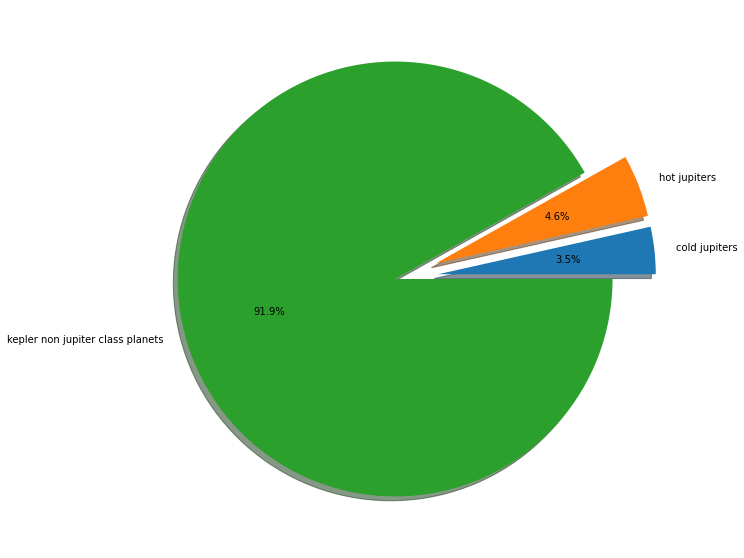

In [13]:
a = cj/data
b = hj/data
c = (data-(cj+hj))/len(skep)
y = np.array([a, b, c])
plt.pie(y, explode=[0.2,0.2,0], labels=['cold jupiters', 'hot jupiters', 'kepler non jupiter class planets'], shadow = True, autopct='%1.1f%%')
plt.gcf().set_size_inches((10, 10))
plt.show()

Scatter plot for hot and cold jupiters

Looks like there is a visual outlier for oribital days, these three values are probably fine but makes the graph hard to read. 402000000.0, 8040000.0, and 1790000 are excluded in the graph only for visual reasons.

In [14]:
skep2p = skep2[skep2['pl_orbper'] < 1790000.0]

Cold Jupiter Scatter Plot

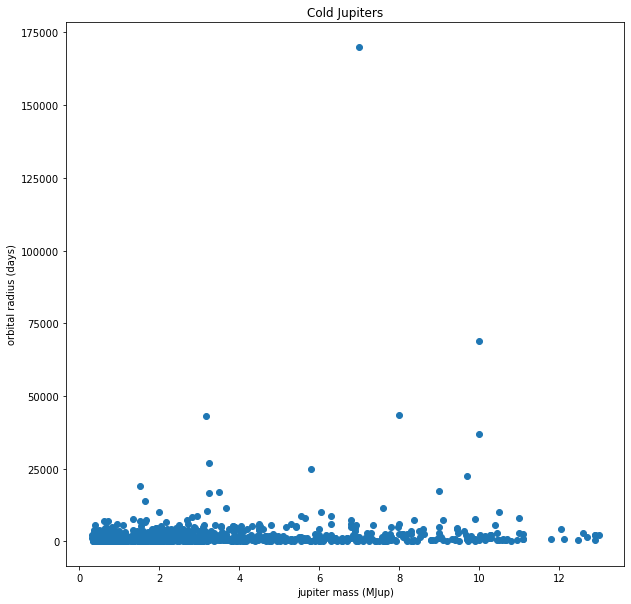

In [15]:
plt.scatter(skep2p['pl_bmassj'], skep2p['pl_orbper'])
plt.xlabel('jupiter mass (MJup)')
plt.ylabel('orbital radius (days)')
plt.title('Cold Jupiters')
plt.gcf().set_size_inches((10, 10))
plt.show() 

Hot Jupiter Scatter Plot

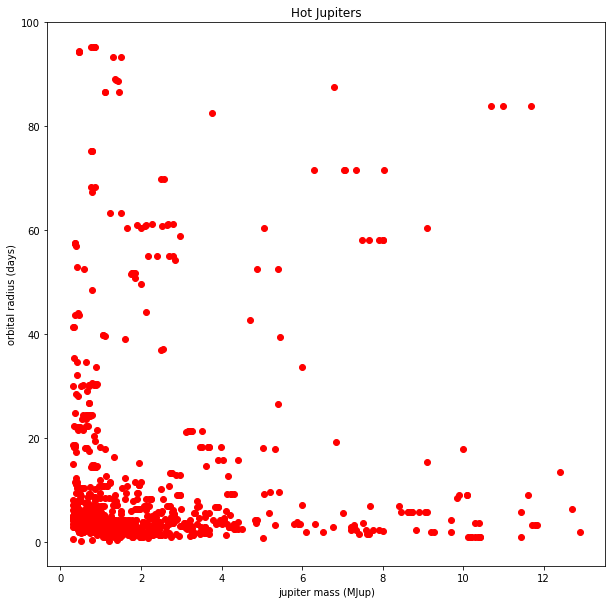

In [16]:
plt.scatter(skep3['pl_bmassj'], skep3['pl_orbper'], c = 'red')
plt.xlabel('jupiter mass (MJup)')
plt.ylabel('orbital radius (days)')
plt.title('Hot Jupiters')
plt.gcf().set_size_inches((10, 10))
plt.show() 

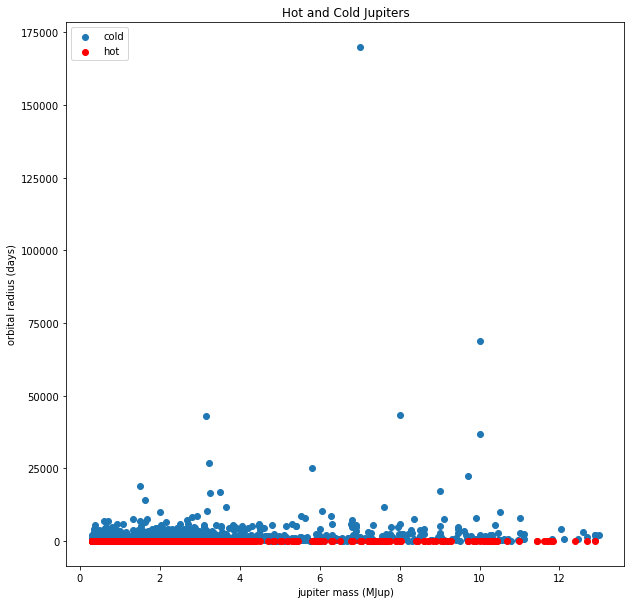

In [17]:
plt.scatter(skep2p['pl_bmassj'], skep2p['pl_orbper'], label = 'cold')
plt.scatter(skep3['pl_bmassj'], skep3['pl_orbper'], c = 'red', label = 'hot')
plt.xlabel('jupiter mass (MJup)')
plt.ylabel('orbital radius (days)')
plt.title('Hot and Cold Jupiters')
plt.legend(loc='upper left')
plt.gcf().set_size_inches((10, 10))
plt.show() 

Conclusion:
    
These results show that the number of hot and cold jupiters is almost the same, with ther being slightly more hot jupiters, which contradicts the paper. This may be because of how many planets we had to exclude due to an unkown mass which was a large percentage of the data base. We were also disapointed how hot and cold jupiters are not defined by stellar temperature, which we think would have an impact on the disscusion of which is more common. It can also be seen that there are far more planets that are not jupiters then are.

In [18]:
cleanSkep = skep.dropna()
dfTrain = cleanSkep.iloc[:, lambda df: [1]]
dfTrain = dfTrain.dropna()

In [19]:
dfTrain.info()

print(dfTrain)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4134 entries, 0 to 32111
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pl_bmassj  4134 non-null   float64
dtypes: float64(1)
memory usage: 64.6 KB
       pl_bmassj
0          19.40
3          14.74
4          10.50
6           4.80
7           4.85
...          ...
32106       3.95
32107       4.10
32108      10.25
32109       0.51
32111       2.80

[4134 rows x 1 columns]


In [20]:
scaler = MinMaxScaler(feature_range =(0,1))
scaled_df = scaler.fit_transform(dfTrain)
scaled_df.shape

(4134, 1)

In [21]:
X_train = []
y_train = []

for i in range (10,4134): #1 : timestep //length of data
    X_train.append(scaled_df[i-10:i,0]) 
    y_train.append(scaled_df[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

In [22]:
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(4124, 10, 1)


We decided to use an LSTM as they are highly capable at at advanced value interpolaiton with a high degree of accuracy. This is because our original data set had a lot of Nans (85% for the jupiter masses) which gave us rather poor prediction capabilities. 

In [23]:
#initializing the RNN
regressor = Sequential()


#Using LSTM (I tried a few other RNN types but this seemed to work the best)
#Adding the first layer LSTM and some Dropout Regularisations
regressor.add(LSTM(units = 100, return_sequences= True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding the second layer LSTM and some Dropout Regularisations
regressor.add(LSTM(units = 100, return_sequences= True))
regressor.add(Dropout(0.2))


#Adding the Third layer LSTM and some Dropout Regularisations
regressor.add(LSTM(units = 100, return_sequences= True))
regressor.add(Dropout(0.2))

#Adding the Fourth Layer LSTM and some Dropout Regularisations
regressor.add(LSTM(units = 100, return_sequences= True))
regressor.add(Dropout(0.2))

#Adding the Fifth and final layer layer LSTM and some Dropout Regularisations
regressor.add(LSTM(units = 100, return_sequences= False))
regressor.add(Dropout(0.2))
#adds a denisty layer with 1 unit
regressor.add(Dense(units = 1))

#compiles model using adamax optimizer and includes accuracy metric and mean squared error
#Tried several other options adamax did the best with the next best being adam
regressor.compile(optimizer ='Adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [24]:
#Trains model and jit function to reduce native call time
@jit(forceobj=True)
def trainModel(X_train, y_train):
    hist = regressor.fit(X_train, y_train, epochs=250, batch_size=32, verbose=2)
    return hist
    
    
hist = trainModel(X_train, y_train)

Epoch 1/250
129/129 - 7s - loss: 0.0021 - accuracy: 2.4248e-04 - 7s/epoch - 58ms/step
Epoch 2/250
129/129 - 1s - loss: 0.0021 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 3/250
129/129 - 1s - loss: 0.0020 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 4/250
129/129 - 1s - loss: 0.0020 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 5/250
129/129 - 1s - loss: 0.0018 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 6/250
129/129 - 1s - loss: 0.0018 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 7/250
129/129 - 1s - loss: 0.0017 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 8/250
129/129 - 1s - loss: 0.0017 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 9/250
129/129 - 1s - loss: 0.0017 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 10/250
129/129 - 1s - loss: 0.0017 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 11/250
129/129 - 1s - loss: 0.0017 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 12/250
129/129 - 1s - loss: 0.0017 - accuracy:

Epoch 96/250
129/129 - 1s - loss: 0.0016 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 97/250
129/129 - 1s - loss: 0.0016 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 98/250
129/129 - 1s - loss: 0.0016 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 99/250
129/129 - 1s - loss: 0.0016 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 100/250
129/129 - 1s - loss: 0.0016 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 101/250
129/129 - 1s - loss: 0.0016 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 102/250
129/129 - 1s - loss: 0.0016 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 103/250
129/129 - 1s - loss: 0.0016 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 104/250
129/129 - 1s - loss: 0.0016 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 105/250
129/129 - 1s - loss: 0.0016 - accuracy: 2.4248e-04 - 1s/epoch - 10ms/step
Epoch 106/250
129/129 - 1s - loss: 0.0016 - accuracy: 2.4248e-04 - 1s/epoch - 11ms/step
Epoch 107/250
129/129 - 1s - loss: 0

Epoch 189/250
129/129 - 1s - loss: 9.0105e-04 - accuracy: 4.8497e-04 - 1s/epoch - 11ms/step
Epoch 190/250
129/129 - 1s - loss: 9.0461e-04 - accuracy: 4.8497e-04 - 1s/epoch - 11ms/step
Epoch 191/250
129/129 - 1s - loss: 9.5744e-04 - accuracy: 4.8497e-04 - 1s/epoch - 11ms/step
Epoch 192/250
129/129 - 1s - loss: 9.7988e-04 - accuracy: 4.8497e-04 - 1s/epoch - 11ms/step
Epoch 193/250
129/129 - 1s - loss: 0.0010 - accuracy: 4.8497e-04 - 1s/epoch - 10ms/step
Epoch 194/250
129/129 - 1s - loss: 9.2178e-04 - accuracy: 4.8497e-04 - 1s/epoch - 11ms/step
Epoch 195/250
129/129 - 1s - loss: 8.5941e-04 - accuracy: 4.8497e-04 - 1s/epoch - 10ms/step
Epoch 196/250
129/129 - 1s - loss: 9.7498e-04 - accuracy: 4.8497e-04 - 1s/epoch - 10ms/step
Epoch 197/250
129/129 - 1s - loss: 9.9624e-04 - accuracy: 4.8497e-04 - 1s/epoch - 10ms/step
Epoch 198/250
129/129 - 1s - loss: 9.6144e-04 - accuracy: 4.8497e-04 - 1s/epoch - 11ms/step
Epoch 199/250
129/129 - 1s - loss: 8.9514e-04 - accuracy: 4.8497e-04 - 1s/epoch - 11

Shows training loss per epoc which gives us an an idea how close the model gets to the actual value, if the loss hits 0 we are on the exact value.

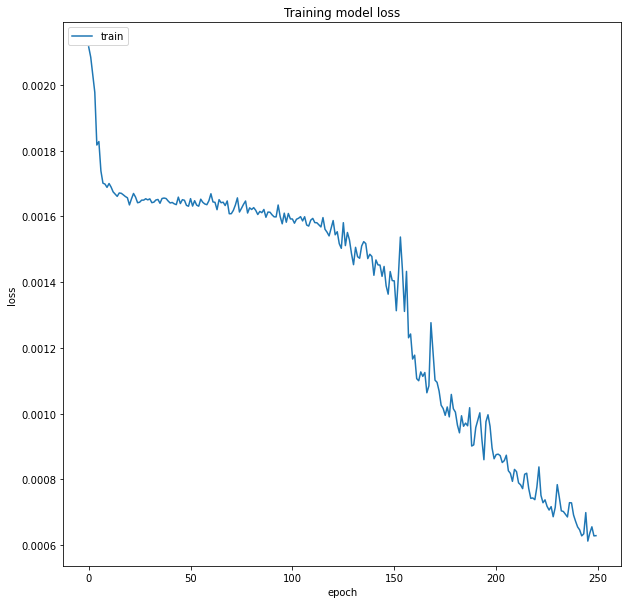

In [25]:
plt.plot(hist.history['loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.gcf().set_size_inches((10, 10))
plt.show()

This code takes the original kepler data and basically compares what the values our model would predict that data to be vs the actual.

In [26]:
testData =  skep
testData['pl_bmassj'] = skep['pl_bmassj'].fillna(-1)
testData = testData.iloc[:, lambda df: [1]]
testData = testData.sort_index(ascending=False)
y_test = testData.iloc[10:,0:].values 
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = scaler.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 10
for i in range(timestep,length):  
    X_test.append(inputClosing_scaled[i-timestep:i,0])
   # print(X_test)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(32102, 10, 1)

After reshaping the numpy array it feeds it to our model and makes a prediction with it.

In [27]:
y_pred = regressor.predict(X_test)

More reshaping so that we can graph them

In [28]:
y_pred = np.reshape(y_pred,(y_pred.shape[0],y_pred.shape[1]))
print(X_train.shape)
pred_massj = scaler.inverse_transform(y_pred)
print((pred_massj))

(4124, 10, 1)
[[ 6.9583163]
 [ 2.8429842]
 [ 4.553269 ]
 ...
 [ 0.8853611]
 [ 5.092422 ]
 [12.966175 ]]


shows model estimations vs actual values

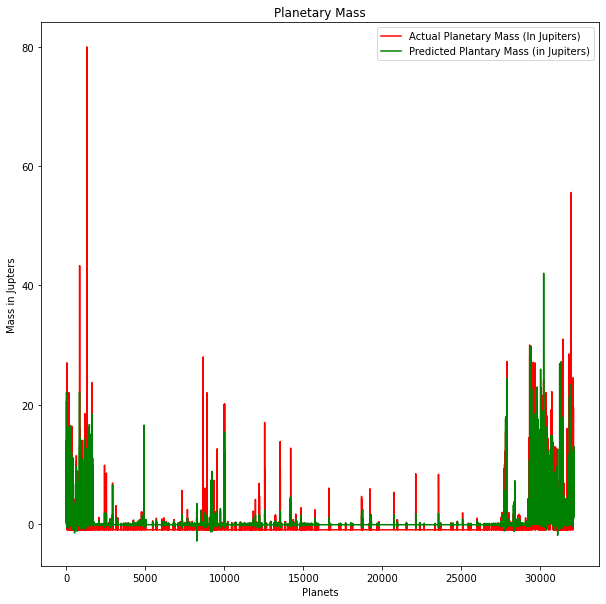

In [29]:
plt.plot(y_test, color = 'red', label = 'Actual Planetary Mass (In Jupiters)')
plt.plot(pred_massj, color = 'green', label = 'Predicted Plantary Mass (in Jupiters)')
plt.title('Planetary Mass')
plt.xlabel('Planets')
plt.ylabel('Mass in Jupters')
plt.gcf().set_size_inches((10, 10))
plt.legend()
plt.show()

Now that we actual estimate values the next few cells take all that into a dataframe and then merge it with know values and fills in the unknowns with estimated values.

In [30]:
pred_massj = pred_massj.flatten()

In [31]:
dfResultMass = pd.DataFrame(pred_massj)

In [32]:
dfResultMass

,0
0,6.958316
1,2.842984
2,4.553269
3,1.242292
4,1.179567
...,...
32097,3.008099
32098,3.228496
32099,0.885361
32100,5.092422


In [33]:
#make new data frame that takes all known planets with jupiter masses + unknowns = -1

In [34]:
newSkep = skep
newSkep['pl_bmassj'] = newSkep['pl_bmassj'].fillna(-1)

In [35]:
newSkep

,pl_name,pl_bmassj,pl_orbper
0,11 Com b,19.40,326.03000
1,11 Com b,17.10,NaN
2,11 UMi b,10.80,NaN
3,11 UMi b,14.74,516.21997
4,11 UMi b,10.50,516.22000
...,...,...,...
32107,ups And d,4.10,1282.41000
32108,ups And d,10.25,1281.50700
32109,ups Leo b,0.51,385.20000
32110,xi Aql b,2.02,NaN


In [36]:
n = 0
for row in newSkep['pl_bmassj']:
    if row == -1:
        newSkep.iloc[n, newSkep.columns.get_loc("pl_bmassj")] = dfResultMass.iloc[n, dfResultMass.columns.get_loc(0)]
    n += 1

In [37]:
newSkep

,pl_name,pl_bmassj,pl_orbper
0,11 Com b,19.40,326.03000
1,11 Com b,17.10,NaN
2,11 UMi b,10.80,NaN
3,11 UMi b,14.74,516.21997
4,11 UMi b,10.50,516.22000
...,...,...,...
32107,ups And d,4.10,1282.41000
32108,ups And d,10.25,1281.50700
32109,ups Leo b,0.51,385.20000
32110,xi Aql b,2.02,NaN


We now repeat the process above but with our new completed data which has real + neural estimations

In [38]:
testData =  newSkep
testData['pl_bmassj'] = skep['pl_bmassj'].fillna(-1)
testData = testData.iloc[:, lambda df: [1]]
testData = testData.sort_index(ascending=False)
y_test = testData.iloc[10:,0:].values 
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = scaler.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 10
for i in range(timestep,length):  
    X_test.append(inputClosing_scaled[i-timestep:i,0])
   # print(X_test)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(32102, 10, 1)

In [39]:
y_pred = regressor.predict(X_test)

In [40]:
y_pred = np.reshape(y_pred,(y_pred.shape[0],y_pred.shape[1]))
print(X_train.shape)
pred_massj = scaler.inverse_transform(y_pred)
print((pred_massj))

(4124, 10, 1)
[[ 6.9583163]
 [ 2.8429842]
 [ 4.553269 ]
 ...
 [ 0.8853611]
 [ 5.092422 ]
 [12.966175 ]]


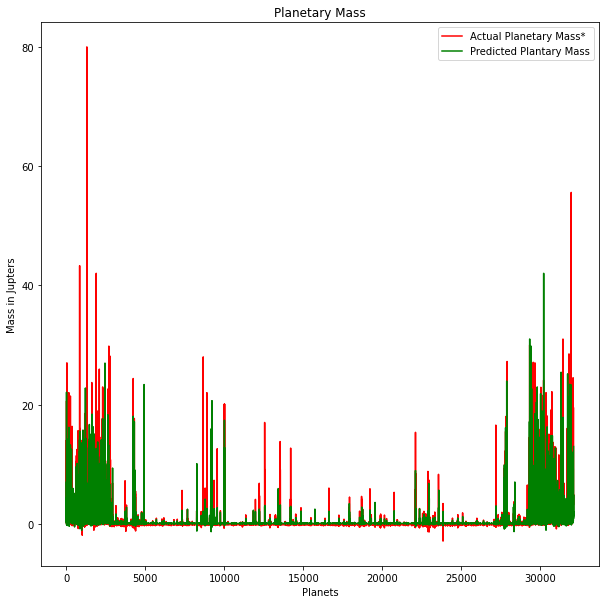

In [41]:
plt.plot(y_test, color = 'red', label = 'Actual Planetary Mass*')
plt.plot(pred_massj, color = 'green', label = 'Predicted Plantary Mass')
plt.title('Planetary Mass')
plt.xlabel('Planets')
plt.ylabel('Mass in Jupters')
plt.gcf().set_size_inches((10, 10))
plt.legend()
plt.show()

Now we are ready to see the ratio of hot vs cold jupiters with interpolated data. So we calculate the hot and cold jupiter percentages like before but now using our filled in data.

We decided to drop the oribital period nans and focus on interpolating masses. At only about 8% the statisical impact is not massive and most of the time things will trend toward the middle on a data set this large anyway.

In [42]:
#Calc hot jupiters
newSkep = newSkep.dropna()
skepFinalHot = newSkep[newSkep['pl_bmassj'] > 0.3] #jupiter mass
skepFinalHot = skepFinalHot[skepFinalHot['pl_bmassj'] < 13] #gets rid of brown dwarfs which are 13 jupiter masses or higher
skepFinalHot = skepFinalHot[skepFinalHot['pl_orbper'] <= 100] #orbital period
skepFinalHot

,pl_name,pl_bmassj,pl_orbper
27,24 Boo b,0.9100,30.350600
59,51 Peg b,0.4640,4.230797
60,51 Peg b,0.4720,4.230785
61,51 Peg b,0.4680,4.230770
62,51 Peg b,0.4600,4.231000
...,...,...,...
32092,ups And b,0.6800,4.611000
32093,ups And b,0.6900,4.617080
32094,ups And b,0.6720,4.617136
32095,ups And b,0.6750,4.617122


In [43]:
#Calc Cold
newSkep = newSkep.dropna()
skepFinalCold = newSkep[newSkep['pl_bmassj'] > 0.3] #jupiter mass
skepFinalCold = skepFinalCold[skepFinalCold['pl_bmassj'] < 13] #gets rid of brown dwarfs which are 13 jupiter masses or higher
skepFinalCold = skepFinalCold[skepFinalCold['pl_orbper'] > 100] #orbital period
skepFinalCold

,pl_name,pl_bmassj,pl_orbper
4,11 UMi b,10.500,516.220
6,14 And b,4.800,185.840
7,14 Her b,4.850,1766.410
8,14 Her b,4.890,1724.000
9,14 Her b,4.975,1766.000
...,...,...,...
32106,ups And d,3.950,1274.600
32107,ups And d,4.100,1282.410
32108,ups And d,10.250,1281.507
32109,ups Leo b,0.510,385.200


Final Graph with our interpolated much better data and our same general trend as before was found but hot is actually way more common than cold jupiters

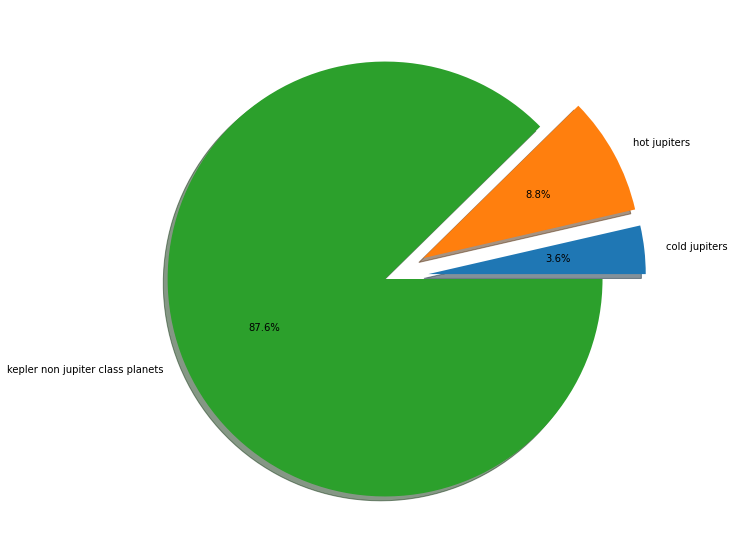

In [44]:
dataFinal = len(newSkep)
cjFinal = len(skepFinalCold)
hjFinal = len(skepFinalHot)
a = cjFinal/dataFinal
b = hjFinal/dataFinal
c = (data-(cj+hj))/len(newSkep)
y = np.array([a, b, c])
plt.pie(y, explode=[0.2,0.2,0], labels=['cold jupiters', 'hot jupiters', 'kepler non jupiter class planets'], shadow = True, autopct='%1.1f%%')
plt.gcf().set_size_inches((10, 10))
plt.show()

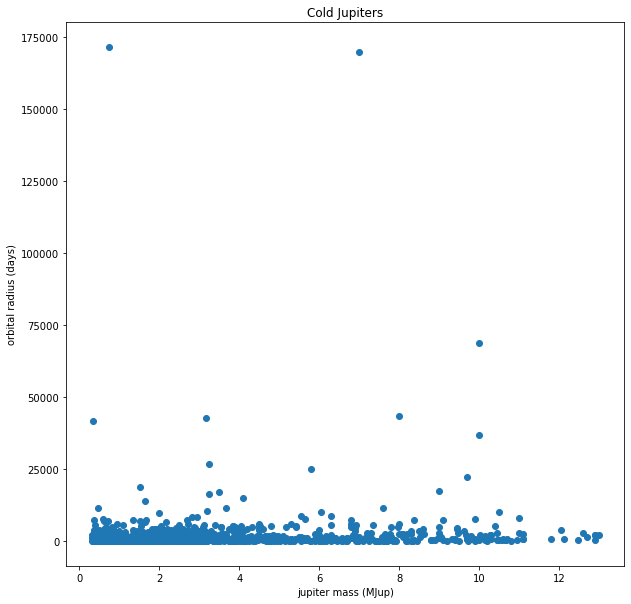

In [45]:
skepFinalCold2 = skepFinalCold[skepFinalCold['pl_orbper'] < 1790000.0]
plt.scatter(skepFinalCold2['pl_bmassj'], skepFinalCold2['pl_orbper'])
plt.xlabel('jupiter mass (MJup)')
plt.ylabel('orbital radius (days)')
plt.title('Cold Jupiters')
plt.gcf().set_size_inches((10, 10))
plt.show() 

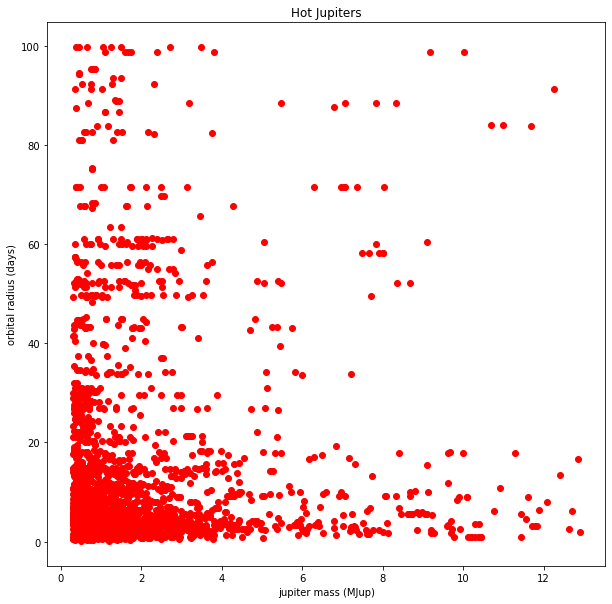

In [46]:
plt.scatter(skepFinalHot['pl_bmassj'], skepFinalHot['pl_orbper'], c = 'red')
plt.xlabel('jupiter mass (MJup)')
plt.ylabel('orbital radius (days)')
plt.title('Hot Jupiters')
plt.gcf().set_size_inches((10, 10))
plt.show() 

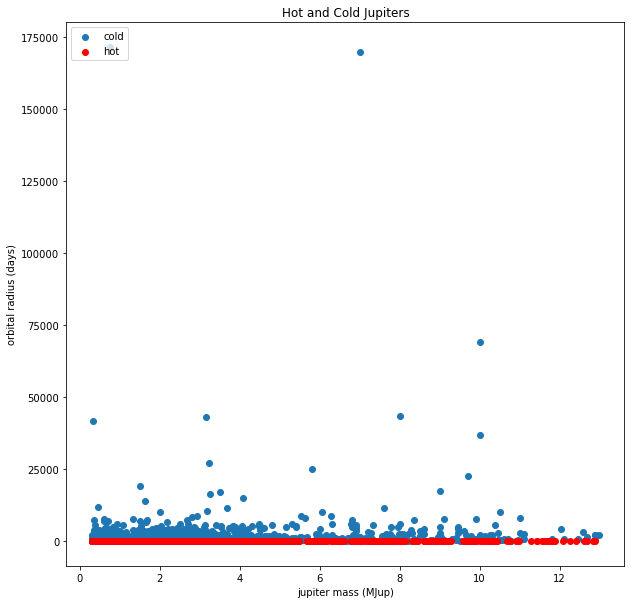

In [47]:
plt.scatter(skepFinalCold2['pl_bmassj'], skepFinalCold2['pl_orbper'], label = 'cold')
plt.scatter(skepFinalHot['pl_bmassj'], skepFinalHot['pl_orbper'], c = 'red', label = 'hot')
plt.xlabel('jupiter mass (MJup)')
plt.ylabel('orbital radius (days)')
plt.title('Hot and Cold Jupiters')
plt.legend(loc='upper left')
plt.gcf().set_size_inches((10, 10))
plt.show() 

So Final Conclusion time. We basically repeated a more extreme version of our earlier results and actually refuted the findings of the paper but the paper only looked at a sample size of 38 exoplanets, whereas our project sets out to look at all of the exoplanets in the Kepler data base. The entire kepler data base minus the 8% or so things without known orbital periods we dropped and did not interpolate back is over 30000, so quite literally almost 1000x